TODO:
- [ ] Define the turbo-code graph structure as a function of the interleaver
- [ ] Write greedy elimination order search outer script
- [ ] Write heuristic metric subroutine
- [ ] Add stochasticity

In [1]:
import networkx as nx
import numpy as np
from typing import List, Callable
from numbers import Number
from math import log2

%load_ext autoreload
%autoreload 2

In [2]:
def connect_nodes(G: nx.Graph, nodes: List[str], inplace=False):
    if not inplace:
        G = G.copy()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if not G.has_edge(nodes[i], nodes[j]):
                # print(f"Adding edge from {nodes[i]} to {nodes[j]}")
                G.add_edge(nodes[i], nodes[j])
    return G

def greedy_ordering(G: nx.Graph, metric: Callable[[nx.Graph, str], Number]):
    ordering = []
    G = G.copy()
    num_nodes = len(G.nodes)
    for _ in range(num_nodes):
        minimizer = min([node for node in G.nodes()], key=lambda node: metric(G, node))
        ordering.append(minimizer)
        neighbors = list(nx.neighbors(G, minimizer))
        G = connect_nodes(G, nodes=neighbors, inplace=True)
        G.remove_node(minimizer)
    
    
    return ordering

def stochastic_greedy_ordering(G: nx.Graph, metric: Callable[[nx.Graph, str], Number], sample_thresh=5, rng: np.random.Generator=None):
    if rng is None:
        rng = np.random.default_rng()
    ordering = []
    G = G.copy()
    num_nodes = len(G.nodes)
    for _ in range(num_nodes):
        sorted_nodes = sorted([node for node in G.nodes()], key=lambda node: metric(G, node))
        minimizer = rng.choice(sorted_nodes[:sample_thresh])
        ordering.append(minimizer)
        neighbors = list(nx.neighbors(G, minimizer))
        G = connect_nodes(G, nodes=neighbors, inplace=True)
        G.remove_node(minimizer)
    
    
    return ordering
        
def min_neighbors(G: nx.Graph, node: str) -> Number:
    return len(list(nx.neighbors(G, node)))

def min_weight(G: nx.Graph, node: str) -> Number:
    return int(np.prod([G.nodes[neighb]["weight"] for neighb in nx.neighbors(G, node)]))

def min_fill(G: nx.Graph, node: str) -> Number:
    neighbors = list(nx.neighbors(G, node))
    new_edges = 0
    for i in range(len(neighbors)):
        for j in range(i+1, len(neighbors)):
            if not G.has_edge(neighbors[i], neighbors[j]):
                new_edges += 1
    return new_edges

def weighted_min_fill(G: nx.Graph, node: str) -> Number:
    neighbors = list(nx.neighbors(G, node))
    edge_cost = 0
    for i in range(len(neighbors)):
        for j in range(i+1, len(neighbors)):
            if not G.has_edge(neighbors[i], neighbors[j]):
                edge_cost += G.nodes[neighbors[i]]["weight"] * G.nodes[neighbors[j]]["weight"]
    return edge_cost

def compute_elimination_factors(G: nx.Graph, ordering: List[str]):
    G = G.copy()
    factors = []
    factor_log_weights = []
    for v in ordering:
        neighbors = list(nx.neighbors(G, v))
        factors.append(neighbors)
        factor_log_weights.append(sum([int(log2(G.nodes[n]["weight"])) for n in neighbors]))
        G = connect_nodes(G, nodes=neighbors, inplace=True)
        G.remove_node(v)
    
    return factors, factor_log_weights

Graph is chordal: True


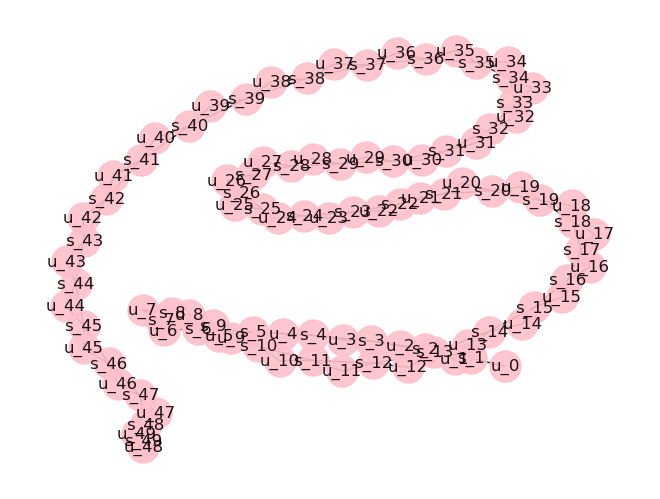

In [3]:
def add_factors(G, input_nodes: List[str], state_symbol: str, state_size, input_size=1):
    G = G.copy()
    length = len(input_nodes)
    for i, input_node in enumerate(input_nodes):
        state_i = f"{state_symbol}_{i}"
        state_i_p_1 = f"{state_symbol}_{i+1}"
        cycle_state = [input_node] + ([state_i] if i > 0 else []) + ([state_i_p_1] if i+1 < length else [])
        nx.add_cycle(G, cycle_state)
        G.nodes[input_node]["weight"] = 2 ** input_size
        if i > 0:
            G.nodes[state_i]["weight"] = 2 ** state_size
        if i+1 < length:
            G.nodes[state_i_p_1]["weight"] = 2 ** state_size
    return G

def make_convcode_graph(length=100, state_size=4):
    G = nx.Graph()
    # create cycles for each factor
    input_nodes = [f"u_{i}" for i in range(length)]
    G = add_factors(G, input_nodes=input_nodes, state_symbol="s", state_size=state_size)
    return G

c_graph = make_convcode_graph(length=50)
print(f"Graph is chordal: {nx.is_chordal(c_graph)}")

pos = nx.spring_layout(c_graph)
nx.draw(c_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9, labels={node: node for node in c_graph.nodes()})

In [4]:
metrics = [min_neighbors, min_weight, min_fill, weighted_min_fill]
for m in metrics:
    print(f"====== {m.__name__} ========")
    elimination_ordering = greedy_ordering(c_graph, m)
    f, fw = compute_elimination_factors(c_graph, elimination_ordering)
    print(elimination_ordering)
    print(f)
    print(max(fw))

====== min_neighbors ========
['u_0', 'u_49', 's_1', 'u_1', 's_2', 'u_2', 's_3', 'u_3', 's_4', 'u_4', 's_5', 'u_5', 's_6', 'u_6', 's_7', 'u_7', 's_8', 'u_8', 's_9', 'u_9', 's_10', 'u_10', 's_11', 'u_11', 's_12', 'u_12', 's_13', 'u_13', 's_14', 'u_14', 's_15', 'u_15', 's_16', 'u_16', 's_17', 'u_17', 's_18', 'u_18', 's_19', 'u_19', 's_20', 'u_20', 's_21', 'u_21', 's_22', 'u_22', 's_23', 'u_23', 's_24', 'u_24', 's_25', 'u_25', 's_26', 'u_26', 's_27', 'u_27', 's_28', 'u_28', 's_29', 'u_29', 's_30', 'u_30', 's_31', 'u_31', 's_32', 'u_32', 's_33', 'u_33', 's_34', 'u_34', 's_35', 'u_35', 's_36', 'u_36', 's_37', 'u_37', 's_38', 'u_38', 's_39', 'u_39', 's_40', 'u_40', 's_41', 'u_41', 's_42', 'u_42', 's_43', 'u_43', 's_44', 'u_44', 's_45', 'u_45', 's_46', 'u_46', 's_47', 'u_47', 's_48', 'u_48', 's_49']
[['s_1'], ['s_49'], ['u_1', 's_2'], ['s_2'], ['u_2', 's_3'], ['s_3'], ['u_3', 's_4'], ['s_4'], ['u_4', 's_5'], ['s_5'], ['u_5', 's_6'], ['s_6'], ['u_6', 's_7'], ['s_7'], ['u_7', 's_8'], ['s_8'], [

In [5]:
c_j_tree = nx.junction_tree(c_graph)
nodes = list(c_j_tree.nodes)
path = next(nx.all_simple_edge_paths(c_j_tree, nodes[0], nodes[-1]))
print(path)

# pos = nx.spring_layout(c_j_tree)
# nx.draw(c_j_tree, pos, edge_color='black', width=1, linewidths=1,
#     node_size=500, node_color='pink', alpha=0.9, labels={node: node for node in c_j_tree.nodes()})

[(('s_1', 'u_0'), ('s_1',)), (('s_1',), ('s_1', 's_2', 'u_1')), (('s_1', 's_2', 'u_1'), ('s_2',)), (('s_2',), ('s_2', 's_3', 'u_2')), (('s_2', 's_3', 'u_2'), ('s_3',)), (('s_3',), ('s_3', 's_4', 'u_3')), (('s_3', 's_4', 'u_3'), ('s_4',)), (('s_4',), ('s_4', 's_5', 'u_4')), (('s_4', 's_5', 'u_4'), ('s_5',)), (('s_5',), ('s_5', 's_6', 'u_5')), (('s_5', 's_6', 'u_5'), ('s_6',)), (('s_6',), ('s_6', 's_7', 'u_6')), (('s_6', 's_7', 'u_6'), ('s_7',)), (('s_7',), ('s_7', 's_8', 'u_7')), (('s_7', 's_8', 'u_7'), ('s_8',)), (('s_8',), ('s_8', 's_9', 'u_8')), (('s_8', 's_9', 'u_8'), ('s_9',)), (('s_9',), ('s_10', 's_9', 'u_9')), (('s_10', 's_9', 'u_9'), ('s_10',)), (('s_10',), ('s_10', 's_11', 'u_10')), (('s_10', 's_11', 'u_10'), ('s_11',)), (('s_11',), ('s_11', 's_12', 'u_11')), (('s_11', 's_12', 'u_11'), ('s_12',)), (('s_12',), ('s_12', 's_13', 'u_12')), (('s_12', 's_13', 'u_12'), ('s_13',)), (('s_13',), ('s_13', 's_14', 'u_13')), (('s_13', 's_14', 'u_13'), ('s_14',)), (('s_14',), ('s_14', 's_15

In [6]:
from src.graphs import greedy_ordering, compute_elimination_factors, build_cluster_tree, prune_cluster_tree, check_cluster_tree, min_weight

elimination_ordering = greedy_ordering(c_graph, metric=min_weight)

factors, _ = compute_elimination_factors(c_graph, elimination_ordering)
c_tree = build_cluster_tree(factors)

pos = nx.spring_layout(c_graph)
nx.draw(c_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9, labels={node: node for node in c_graph.nodes()})

u_0
['s_1']
u_49
['s_49']
s_1
['u_1', 's_2']
u_1
['s_2']
s_2
['u_2', 's_3']
u_2
['s_3']
s_3
['u_3', 's_4']
u_3
['s_4']
s_4
['u_4', 's_5']
u_4
['s_5']
s_5
['u_5', 's_6']
u_5
['s_6']
s_6
['u_6', 's_7']
u_6
['s_7']
s_7
['u_7', 's_8']
u_7
['s_8']
s_8
['u_8', 's_9']
u_8
['s_9']
s_9
['u_9', 's_10']
u_9
['s_10']
s_10
['u_10', 's_11']
u_10
['s_11']
s_11
['u_11', 's_12']
u_11
['s_12']
s_12
['u_12', 's_13']
u_12
['s_13']
s_13
['u_13', 's_14']
u_13
['s_14']
s_14
['u_14', 's_15']
u_14
['s_15']
s_15
['u_15', 's_16']
u_15
['s_16']
s_16
['u_16', 's_17']
u_16
['s_17']
s_17
['u_17', 's_18']
u_17
['s_18']
s_18
['u_18', 's_19']
u_18
['s_19']
s_19
['u_19', 's_20']
u_19
['s_20']
s_20
['u_20', 's_21']
u_20
['s_21']
s_21
['u_21', 's_22']
u_21
['s_22']
s_22
['u_22', 's_23']
u_22
['s_23']
s_23
['u_23', 's_24']
u_23
['s_24']
s_24
['u_24', 's_25']
u_24
['s_25']
s_25
['u_25', 's_26']
u_25
['s_26']
s_26
['u_26', 's_27']
u_26
['s_27']
s_27
['u_27', 's_28']
u_27
['s_28']
s_28
['u_28', 's_29']
u_28
['s_29']
s_29
['u_

TypeError: combinations() missing required argument 'r' (pos 2)

In [3]:
list(nx.neighbors(c_graph, "u_8"))

['s_8', 's_9']

In [4]:
for e in nx.generate_edgelist(c_graph, data=False):
    print(e)
nx.write_edgelist(c_graph, path="../tmp/test_conv_general.graph", data=False)

u_0 s_1
s_1 u_1
s_1 s_2
u_1 s_2
s_2 u_2
s_2 s_3
u_2 s_3
s_3 u_3
s_3 s_4
u_3 s_4
s_4 u_4
s_4 s_5
u_4 s_5
s_5 u_5
s_5 s_6
u_5 s_6
s_6 u_6
s_6 s_7
u_6 s_7
s_7 u_7
s_7 s_8
u_7 s_8
s_8 u_8
s_8 s_9
u_8 s_9
s_9 u_9


[0 4 1 3 2]
Graph is chordal: False


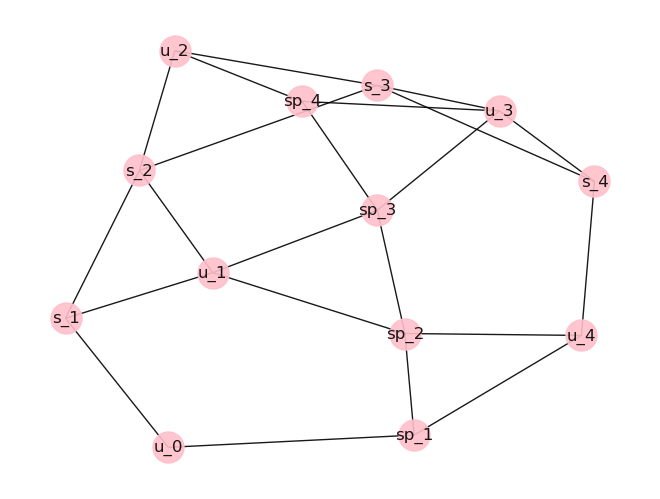

In [9]:
def make_turbo_graph(interleaver_p: np.array, state_size=4):
    assert interleaver_p.ndim == 1
    length = interleaver_p.shape[0]
    G = make_convcode_graph(length=length, state_size=state_size)
    
    print(interleaver_p)
    interleaved_inputs = [f"u_{interleaver_p[i]}" for i in range(length)]
    G = add_factors(G, input_nodes=interleaved_inputs, state_symbol="sp", state_size=state_size)
    
    return G

length=5
rng = np.random.default_rng(seed=1234)
permutation = rng.permutation(length)
t_graph = make_turbo_graph(permutation)
print(f"Graph is chordal: {nx.is_chordal(t_graph)}")

pos = nx.spring_layout(t_graph)
nx.draw(t_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9, labels={node: node for node in t_graph.nodes()})

In [11]:
for e in nx.generate_edgelist(t_graph, data=False):
    print(e)
nx.write_edgelist(t_graph, path="../tmp/test_turbo_general.graph", data=False)

u_0 s_1
u_0 sp_1
s_1 u_1
s_1 s_2
u_1 s_2
u_1 sp_2
u_1 sp_3
s_2 u_2
s_2 s_3
u_2 s_3
u_2 sp_4
s_3 u_3
s_3 s_4
u_3 s_4
u_3 sp_3
u_3 sp_4
s_4 u_4
u_4 sp_1
u_4 sp_2
sp_1 sp_2
sp_2 sp_3
sp_3 sp_4


Graph is chordal: True


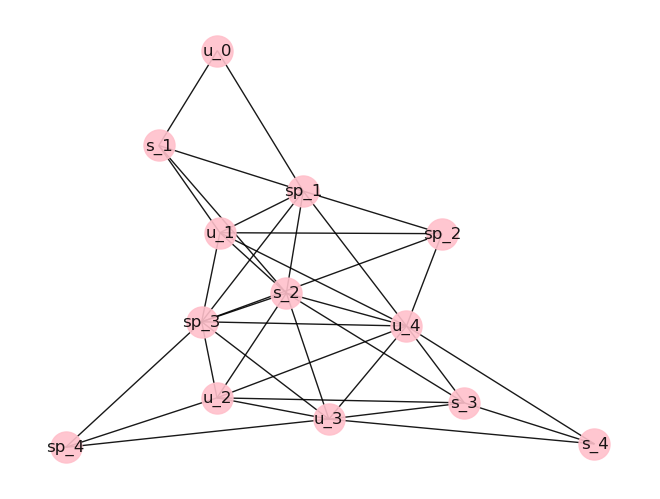

In [20]:
complete_t_graph = t_graph.copy()
complete_t_graph.add_edges_from(nx.read_edgelist(path="../tmp/test_turbo_general.completion.graph").edges)
print(f"Graph is chordal: {nx.is_chordal(complete_t_graph)}")

pos = nx.spring_layout(complete_t_graph)
nx.draw(complete_t_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9, labels={node: node for node in complete_t_graph.nodes()})

In [10]:
t_graph_no_u3 = t_graph.copy()
t_graph_no_u3.remove_node("u_3")
metrics = [min_neighbors, min_weight, min_fill, weighted_min_fill]
for m in metrics:
    print(f"====== {m.__name__} ========")
    elimination_ordering = greedy_ordering(t_graph_no_u3, m)
    f, fw = compute_elimination_factors(t_graph_no_u3, elimination_ordering)
    print(f)
    print(max(fw))

====== min_neighbors ========
[['s_1', "s'_1"], ['s_3', 'u_4'], ['u_2', "s'_3"], ['u_1', 's_2', "s'_1"], ['s_2', 's_3', "s'_3"], ['s_2', 'u_4', "s'_3"], ['s_2', "s'_2", "s'_3", "s'_1"], ["s'_1", "s'_3", 'u_4', "s'_2"], ["s'_1", "s'_2", "s'_3"], ["s'_2", "s'_3"], ["s'_3"], []]
16
====== min_weight ========
[['s_3', 'u_4'], ['u_2', "s'_3"], ['u_0', 'u_1', 's_2'], ['s_2', 'u_2', 'u_4'], ['u_1', 'u_2', 'u_0', 'u_4'], ['u_0', 'u_4', "s'_2"], ['u_1', "s'_2", 'u_2'], ['u_1', 'u_4', 'u_0', 'u_2'], ['u_1', 'u_2', 'u_4'], ['u_2', 'u_4'], ['u_4'], []]
6
====== min_fill ========
[['s_1', "s'_1"], ['s_3', 'u_4'], ['u_2', "s'_3"], ['u_1', 's_2', "s'_1"], ['s_2', 's_3', "s'_3"], ['s_2', "s'_2", "s'_3", "s'_1"], ['s_3', "s'_1", "s'_3", "s'_2"], ["s'_1", "s'_2", 's_3'], ["s'_3", "s'_1", "s'_2"], ["s'_2", "s'_3"], ["s'_3"], []]
16
====== weighted_min_fill ========
[['s_3', 'u_4'], ['u_2', "s'_3"], ['u_0', 'u_1', 's_2'], ['s_2', 'u_2', 'u_4'], ['u_1', 'u_2', 'u_0', 'u_4'], ['u_0', 'u_4', "s'_2"], ['u_1',

Now try with TurboAE interleaver

In [21]:
from src.interleavers import TurboAEInterleaver

interleaver = TurboAEInterleaver()
tae_permutation = interleaver.permutation.numpy()
tae_permutation

array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
       24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
       51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
       59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
       14, 89, 19, 29, 49, 97, 98, 69, 20, 94, 72, 77, 25, 37, 81, 46, 39,
       65, 58, 12, 88, 70, 87, 36, 21, 83,  9, 96, 67, 64, 47, 44])

In [90]:
tae_graph = make_turbo_graph(permutation, state_size=8)
print(len(tae_graph.nodes))
print(f"Graph is chordal: {nx.is_chordal(tae_graph)}")

[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76 60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40
 38  5 91 59  0 34 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29
 49 97 98 69 20 94 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96
 67 64 47 44]
298
Graph is chordal: False


In [92]:
tae_graph_no_u25 = tae_graph.copy()
tae_graph_no_u25.remove_node("u_25")
metrics = [min_neighbors, min_weight, min_fill, weighted_min_fill]
for m in metrics:
    print(f"====== {m.__name__} ========")
    elimination_ordering = greedy_ordering(tae_graph_no_u25, m)
    f, fw = compute_elimination_factors(tae_graph_no_u25, elimination_ordering)
    # print(f)
    print(max(fw))

====== min_neighbors ========
208
====== min_weight ========
111
====== min_fill ========
164
====== weighted_min_fill ========
71


In [160]:
from tqdm import trange

rng=np.random.default_rng(198591)
perm = rng.permutation(100)
tae_graph = make_turbo_graph(perm, state_size=2)
tae_graph_inf = tae_graph.copy()
print(len(tae_graph_inf.nodes))
metrics = [min_neighbors, min_weight, min_fill, weighted_min_fill]
best = float('inf')
best_f = None
best_fw = None
tries = 300
pbar = trange(tries)
for _ in pbar:
    for m in metrics:
        # print(f"====== {m.__name__} ========")
        elimination_ordering = stochastic_greedy_ordering(tae_graph_inf, m, sample_thresh=3, rng=rng)
        f, fw = compute_elimination_factors(tae_graph_inf, elimination_ordering)
        # print(f)
        # print(max(fw))
        res = max(fw)
        if res < best:
            best = res
            best_f = f
            best_fw = fw
            pbar.set_postfix({"best":best})

print(best)
print(best_fw)

[ 4 61 52 13 82 93 63 19 83 64  8 48 72 37 84 89 18 20 79 88 53 98 27 92
 66  1  6 32 56 60 59 15  2 16 44  3 23 29 65 75 97 80 28 42 14 70 58 43
 36 55 86 33  5 10 54 78 51 45  9 30 46 34 87 69 76 95 73 17 31 94 71 57
 40 24 35 91 11 99 21 90 50 47 22 25 62 41 39 96  0 12 67 85 38 68 74 77
 81  7 26 49]
298


 11%|█▏        | 34/300 [02:08<16:45,  3.78s/it, best=60]


KeyboardInterrupt: 

Try with nonrecursive code

Graph is chordal: True


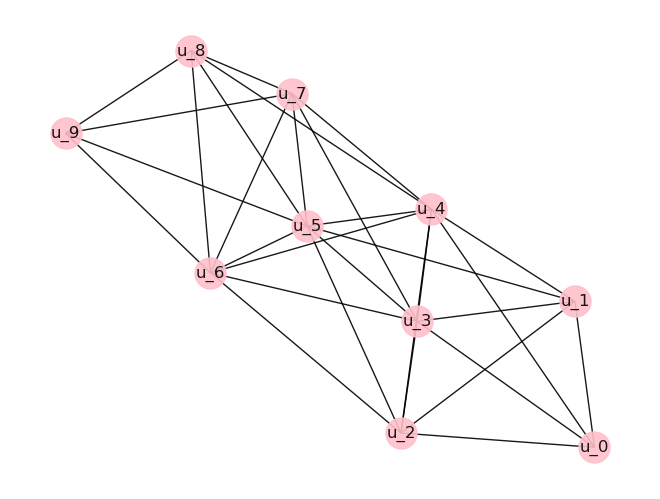

In [22]:
def add_nonrecursive_factors(G, input_nodes: List[str], window, delay, input_size=1):
    G = G.copy()
    for i in range(len(input_nodes)):
        factor = input_nodes[max(0, i - window + 1 + delay):(i + 1 + delay)]
        connect_nodes(G, factor, inplace=True)
    for input_node in input_nodes:
        G.nodes[input_node]["weight"] = 2 ** input_size
    return G

def make_nonrecursive_convcode_graph(length=100, window=5, delay=2):
    G = nx.Graph()
    # create cycles for each factor
    input_nodes = [f"u_{i}" for i in range(length)]
    G = add_nonrecursive_factors(G, input_nodes=input_nodes, window=window, delay=delay)
    return G

nc_graph = make_nonrecursive_convcode_graph(length=10, window=5, delay=2)
print(f"Graph is chordal: {nx.is_chordal(nc_graph)}")

pos = nx.spring_layout(nc_graph)
nx.draw(nc_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9, labels={node: node for node in nc_graph.nodes()})

[ 3  9 18 16  8  5 12 13  0 17 15 11  2  7 10  6  4 14  1 19]
Graph is chordal: False


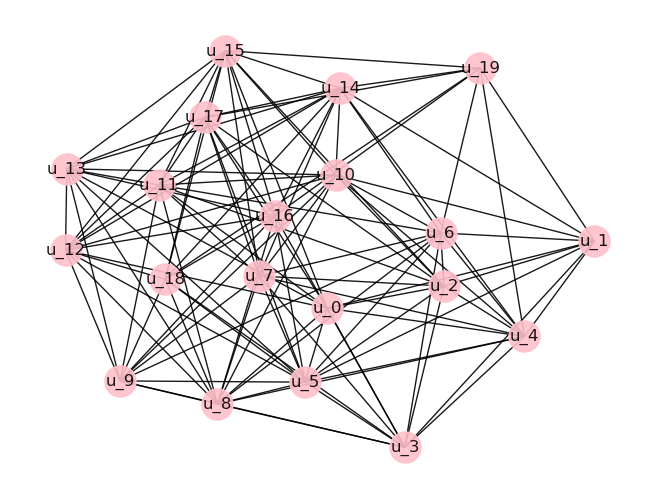

In [25]:
def make_nonrecursive_turbo_graph(interleaver_p: np.array, window=5, delay=2):
    assert interleaver_p.ndim == 1
    length = interleaver_p.shape[0]
    G = make_nonrecursive_convcode_graph(length=length, window=window, delay=delay)
    
    print(interleaver_p)
    interleaved_inputs = [f"u_{interleaver_p[i]}" for i in range(length)]
    G = add_nonrecursive_factors(G, input_nodes=interleaved_inputs, window=window, delay=delay)
    
    return G

length=20
rng = np.random.default_rng(seed=1234)
permutation = rng.permutation(length)
nt_graph = make_nonrecursive_turbo_graph(permutation)
print(f"Graph is chordal: {nx.is_chordal(nt_graph)}")

pos = nx.spring_layout(nt_graph)
nx.draw(nt_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9, labels={node: node for node in nt_graph.nodes()})

[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76 60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40
 38  5 91 59  0 34 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29
 49 97 98 69 20 94 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96
 67 64 47 44]
100
Graph is chordal: False


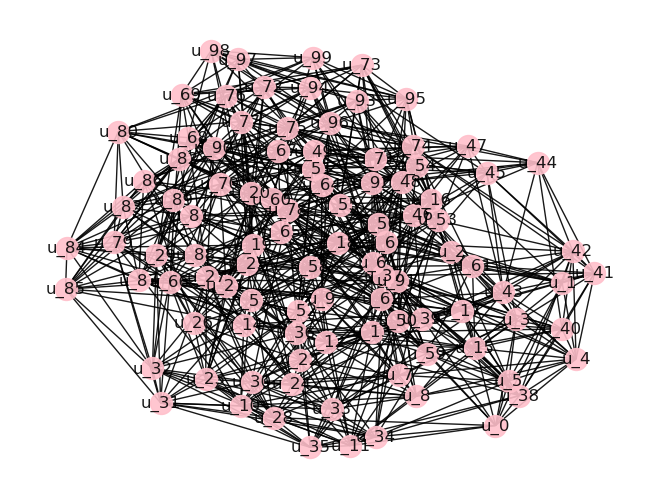

In [26]:
ntae_graph = make_nonrecursive_turbo_graph(tae_permutation)
print(len(ntae_graph.nodes))
print(f"Graph is chordal: {nx.is_chordal(ntae_graph)}")
pos = nx.spring_layout(ntae_graph)
nx.draw(ntae_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=250, node_color='pink', alpha=0.9, labels={node: node for node in ntae_graph.nodes()})

In [27]:
for e in nx.generate_edgelist(ntae_graph, data=False):
    print(e)
nx.write_edgelist(ntae_graph, path="../tmp/turboae_nonrecursive.graph", data=False)

u_0 u_1
u_0 u_2
u_0 u_3
u_0 u_4
u_0 u_38
u_0 u_5
u_0 u_91
u_0 u_59
u_0 u_34
u_0 u_28
u_0 u_50
u_0 u_11
u_1 u_2
u_1 u_3
u_1 u_4
u_1 u_5
u_1 u_18
u_1 u_56
u_1 u_63
u_1 u_74
u_1 u_61
u_1 u_42
u_1 u_41
u_2 u_3
u_2 u_4
u_2 u_5
u_2 u_6
u_2 u_26
u_2 u_86
u_2 u_55
u_2 u_75
u_2 u_93
u_2 u_16
u_3 u_4
u_3 u_5
u_3 u_6
u_3 u_7
u_3 u_33
u_3 u_8
u_3 u_43
u_3 u_62
u_3 u_71
u_3 u_45
u_3 u_48
u_4 u_5
u_4 u_6
u_4 u_7
u_4 u_8
u_4 u_61
u_4 u_42
u_4 u_41
u_4 u_15
u_4 u_17
u_4 u_40
u_4 u_38
u_5 u_6
u_5 u_7
u_5 u_8
u_5 u_9
u_5 u_15
u_5 u_17
u_5 u_40
u_5 u_38
u_5 u_91
u_5 u_59
u_5 u_34
u_6 u_7
u_6 u_8
u_6 u_9
u_6 u_10
u_6 u_71
u_6 u_45
u_6 u_48
u_6 u_99
u_6 u_82
u_6 u_76
u_6 u_60
u_7 u_8
u_7 u_9
u_7 u_10
u_7 u_11
u_7 u_53
u_7 u_92
u_7 u_78
u_7 u_13
u_7 u_30
u_7 u_22
u_7 u_24
u_7 u_33
u_8 u_9
u_8 u_10
u_8 u_11
u_8 u_12
u_8 u_30
u_8 u_22
u_8 u_24
u_8 u_33
u_8 u_43
u_8 u_62
u_8 u_71
u_9 u_10
u_9 u_11
u_9 u_12
u_9 u_13
u_9 u_87
u_9 u_36
u_9 u_21
u_9 u_83
u_9 u_96
u_9 u_67
u_9 u_64
u_9 u_47
u_10 u_11
u_10 u_12
u_10

In [115]:
ntae_graph_no_u25 = ntae_graph.copy()
ntae_graph_no_u25.remove_node("u_0")
print(len(ntae_graph_no_u25.nodes))
metrics = [min_neighbors, min_weight, min_fill, weighted_min_fill]
for m in metrics:
    print(f"====== {m.__name__} ========")
    elimination_ordering = greedy_ordering(ntae_graph_no_u25, m)
    f, fw = compute_elimination_factors(ntae_graph_no_u25, elimination_ordering)
    # print(f)
    print(max(fw))

99
====== min_neighbors ========
60
====== min_weight ========
69
====== min_fill ========
54
====== weighted_min_fill ========
54


In [144]:
from tqdm import trange

rng=np.random.default_rng(198591)
# perm = rng.permutation(58)
ntae_graph = make_nonrecursive_turbo_graph(tae_permutation, window=5, delay=2)
ntae_graph_inf = ntae_graph.copy()
# ntae_graph_inf.remove_node("u_0")
print(len(ntae_graph_inf.nodes))
metrics = [min_neighbors, min_weight, min_fill, weighted_min_fill]
best = float('inf')
best_f = None
best_fw = None
tries = 300
pbar = trange(tries)
for _ in pbar:
    for m in metrics:
        # print(f"====== {m.__name__} ========")
        elimination_ordering = stochastic_greedy_ordering(ntae_graph_inf, m, sample_thresh=5, rng=rng)
        f, fw = compute_elimination_factors(ntae_graph_inf, elimination_ordering)
        # print(f)
        # print(max(fw))
        res = max(fw)
        if res < best:
            best = res
            best_f = f
            best_fw = fw
            pbar.set_postfix({"best":best})

print(best)
print(best_fw)

[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76 60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40
 38  5 91 59  0 34 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29
 49 97 98 69 20 94 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96
 67 64 47 44]
100


100%|██████████| 300/300 [10:16<00:00,  2.06s/it, best=48]

48
None


In [145]:
from pprint import pprint
pprint(best_f)

[['u_19',
  'u_20',
  'u_29',
  'u_49',
  'u_69',
  'u_72',
  'u_94',
  'u_95',
  'u_96',
  'u_97',
  'u_99'],
 ['u_1',
  'u_2',
  'u_3',
  'u_4',
  'u_38',
  'u_5',
  'u_91',
  'u_59',
  'u_34',
  'u_28',
  'u_50',
  'u_11'],
 ['u_9',
  'u_43',
  'u_44',
  'u_45',
  'u_46',
  'u_48',
  'u_49',
  'u_50',
  'u_51',
  'u_96',
  'u_67',
  'u_64'],
 ['u_2',
  'u_26',
  'u_55',
  'u_75',
  'u_82',
  'u_83',
  'u_84',
  'u_85',
  'u_87',
  'u_88',
  'u_89',
  'u_90',
  'u_93'],
 ['u_10',
  'u_11',
  'u_23',
  'u_28',
  'u_31',
  'u_32',
  'u_33',
  'u_34',
  'u_36',
  'u_37',
  'u_38',
  'u_39',
  'u_50',
  'u_52'],
 ['u_1',
  'u_4',
  'u_15',
  'u_17',
  'u_37',
  'u_38',
  'u_39',
  'u_40',
  'u_42',
  'u_43',
  'u_44',
  'u_45',
  'u_74',
  'u_61'],
 ['u_27',
  'u_51',
  'u_60',
  'u_68',
  'u_76',
  'u_77',
  'u_78',
  'u_79',
  'u_81',
  'u_82',
  'u_83',
  'u_84',
  'u_99',
  'u_90'],
 ['u_16',
  'u_50',
  'u_51',
  'u_52',
  'u_53',
  'u_55',
  'u_56',
  'u_57',
  'u_58',
  'u_75',
  

In [147]:
pprint([len(i) for i in best_f])

[11,
 12,
 12,
 13,
 14,
 14,
 14,
 15,
 15,
 17,
 17,
 15,
 21,
 19,
 16,
 19,
 17,
 17,
 17,
 20,
 28,
 30,
 30,
 32,
 29,
 34,
 38,
 40,
 43,
 30,
 43,
 42,
 41,
 31,
 40,
 45,
 45,
 32,
 48,
 47,
 46,
 45,
 45,
 46,
 46,
 46,
 46,
 45,
 44,
 48,
 46,
 47,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0]
